In [8]:
import pylab as plt
import xarray as xr
from pathlib import Path
import geopandas as gp
import rioxarray as rxr
import geopandas as gp
from pism_ragis.processing import preprocess_nc
from pism_ragis.observations import load_imbie, load_mouginot, load_mankoff

In [9]:
kg2cmsle = 1 / 1e12 * 1.0 / 362.5 / 10.0
gt2cmsle = 1 / 362.5 / 10.0

In [10]:
data_dir = Path("/mnt/storstrommen/ragis/data/pism")
assert data_dir.exists()

In [11]:
exp = {"proj_dir": "2024_02_grimp",
    "scalar_dir": "scalar",
    "scalar_processed_dir": "scalar_processed",
    "resolution": 900,
    "spatial_dir": "spatial"}

In [12]:
spatial_url = data_dir / Path(exp["proj_dir"]) / Path(exp["spatial_dir"])
spatial_urls = spatial_url.glob(f"""ex_gris_g{exp["resolution"]}m*.nc""")
spatial_ds = xr.open_mfdataset(spatial_urls, preprocess=preprocess_nc, concat_dim="exp_id", combine="nested", parallel=True)

In [13]:
scalar_url = data_dir / Path(exp["proj_dir"]) / Path(exp["scalar_dir"])
scalar_urls = scalar_url.glob(f"""ts_gris_g{exp["resolution"]}m*.nc""")
scalar_ds = xr.open_mfdataset(scalar_urls, preprocess=preprocess_nc, concat_dim="exp_id", combine="nested", parallel=True)

In [83]:
mou = load_mouginot(url=Path("/mnt/storstrommen/ragis/data/mouginot/pnas.1904242116.sd02.xlsx"), norm_year=1985)
mou_gis = mou[mou["Basin"] == "GIS"]

/home/andy/base/pism-ragis/pism_ragis/observations.py:218: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  df["Date"] = pd.date_range(start="1972-1-1", end="2018-1-1", freq="AS")
/home/andy/base/pism-ragis/pism_ragis/observations.py:218: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  df["Date"] = pd.date_range(start="1972-1-1", end="2018-1-1", freq="AS")
/home/andy/base/pism-ragis/pism_ragis/observations.py:218: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  df["Date"] = pd.date_range(start="1972-1-1", end="2018-1-1", freq="AS")
/home/andy/base/pism-ragis/pism_ragis/observations.py:218: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  df["Date"] = pd.date_range(start="1972-1-1", end="2018-1-1", freq="AS")
/home/andy/base/pism-ragis/pism_ragis/observations.py:218: FutureWar

In [15]:
basins = gp.read_file("../data/basins/Greenland_Basins_PS_v1.4.2.shp").to_crs("EPSG:3413")

In [16]:
spatial_ds.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
spatial_ds.rio.write_crs("epsg:3413", inplace=True)

<xarray.Dataset>
Dimensions:                                         (time: 480, exp_id: 3,
                                                     nv: 2, x: 1760, y: 3040)
Coordinates:
  * time                                            (time) datetime64[ns] 198...
    mapping                                         int64 0
  * x                                               (x) float64 -6.782e+05 .....
  * y                                               (y) float64 -3.371e+06 .....
  * exp_id                                          (exp_id) <U19 'BAYES-MEDI...
Dimensions without coordinates: nv
Data variables: (12/25)
    time_bounds                                     (exp_id, time, nv) datetime64[ns] dask.array<chunksize=(1, 1, 2), meta=np.ndarray>
    pism_config                                     (exp_id) int8 0 0 0
    run_stats                                       (exp_id) float64 0.0 0.0 0.0
    timestamp                                       (exp_id, time) timedelta64[ns] dask.array<chunksize=(1, 480), meta=np.ndarray>
    dHdt                                            (exp_id, time, y, x) float32 dask.array<chunksize=(1, 1, 1014, 587), meta=np.ndarray>
    flux_divergence                                 (exp_id, time, y, x) float32 dask.array<chunksize=(1, 1, 1014, 587), meta=np.ndarray>
    ...                                              ...
    tendency_of_ice_mass_due_to_surface_mass_flux   (exp_id, time, y, x) float32 dask.array<chunksize=(1, 1, 1014, 587), meta=np.ndarray>
    thk                                             (exp_id, time, y, x) float32 dask.array<chunksize=(1, 1, 1014, 587), meta=np.ndarray>
    usurf                                           (exp_id, time, y, x) float32 dask.array<chunksize=(1, 1, 1014, 587), meta=np.ndarray>
    velsurf_mag                                     (exp_id, time, y, x) float32 dask.array<chunksize=(1, 1, 1014, 587), meta=np.ndarray>
    vonmises_calving_rate                           (exp_id, time, y, x) float32 dask.array<chunksize=(1, 1, 1014, 587), meta=np.ndarray>
    sle                                             (exp_id, y, x, time) float32 dask.array<chunksize=(1, 1014, 587, 1), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    command:       /home1/aaschwan/local/pism-dev/bin/pismr -profile /nobacku...
    history:      aaschwan@r445i4n7 2024-03-01 19:25:16 PST: PISM (2024-02-15...
    institution:  University of Alaska Fairbanks
    proj:         epsg:3413
    source:       PISM (2024-02-15-da843103f committed by Constantine Khrulev...

In [37]:
basin_sle = spatial_ds["sle"].rio.clip(basins.geometry).sum(dim=["x", "y"]).compute()
basin_mass = spatial_ds["ice_mass"].rio.clip(basins.geometry).sum(dim=["x", "y"]).compute()

In [38]:
scalar_sle = scalar_ds["sle"].compute()
scalar_mass = scalar_ds["ice_mass"].compute()

In [39]:
domain_sle = spatial_ds["sle"].sum(dim=["x", "y"]).compute()
domain_mass = spatial_ds["ice_mass"].sum(dim=["x", "y"]).compute()

In [87]:
domain_mass_scaled = (domain_mass - domain_mass.isel(time=60)) * kg2cmsle
basin_mass_scaled = (basin_mass - basin_mass.isel(time=60)) * kg2cmsle
scalar_mass_scaled = (scalar_mass - scalar_mass.isel(time=60)) * kg2cmsle

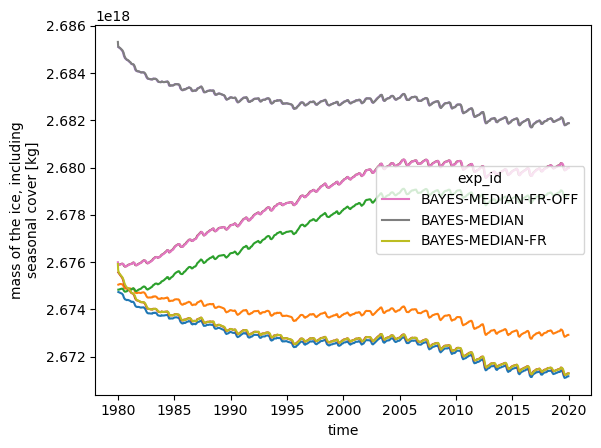

In [88]:
fig = plt.figure()
ax = fig.add_subplot(111)
basin_mass.plot.line(x="time", hue="exp_id", ax=ax)
domain_mass.plot.line(x="time", hue="exp_id", ax=ax)
scalar_mass.plot.line(x="time", hue="exp_id", ax=ax)

(-0.5, 0.5)

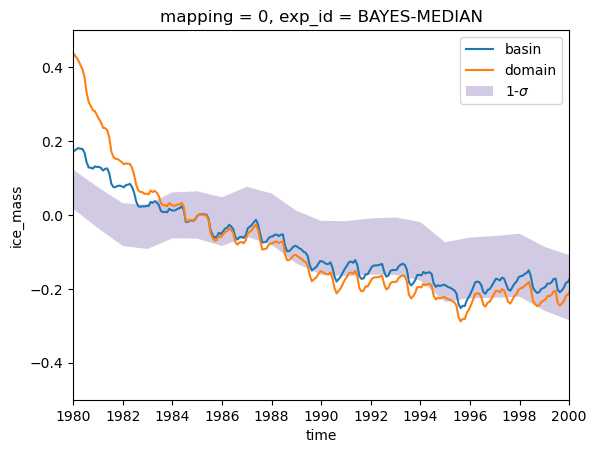

In [97]:
sim_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][1::]
imbie_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
#sim_colors = ["#882255", "#AA4499", "#CC6677", "#DDCC77", "#88CCEE", "#44AA99", "#117733", "#332288"]
imbie_color = "k"
imbie_color = "#238b45"
mou_color = "#6a51a3"

obs = mou_gis
obs_color = mou_color

sigma = 1
mass_varname = "SLE (cm)"
mass_uncertainty_varname = "SLE uncertainty (cm)"
discharge_varname = "Rate of ice discharge (Gt/yr)"
discharge_uncertainty_varname = "Rate of ice discharge uncertainty (Gt/yr)"
smb_varname = "Rate of surface mass balance (Gt/yr)"
smb_uncertainty_varname = "Rate of surface mass balance uncertainty (Gt/yr)"

fig = plt.figure()
ax = fig.add_subplot(111)
basin_mass_scaled.sel(exp_id="BAYES-MEDIAN").plot.line(x="time", ax=ax, label="basin")
domain_mass_scaled.sel(exp_id="BAYES-MEDIAN").plot.line(x="time", ax=ax, label="domain")
obs_ci = ax.fill_between(obs["Date"], 
                    (obs[mass_varname] + sigma * obs[mass_uncertainty_varname]), 
                    (obs[mass_varname] - sigma * obs[mass_uncertainty_varname]), 
                    ls="solid", color=obs_color, lw=0, alpha=0.30, label="1-$\sigma$")
ax.legend()
#scalar_mass.sel(exp_id="BAYES-MEDIAN").plot.line(x="time", ax=ax)
ax.set_xlim(pd.to_datetime("1980-1-1"), pd.to_datetime("2000-1-1"))
ax.set_ylim(-0.5, 0.5)

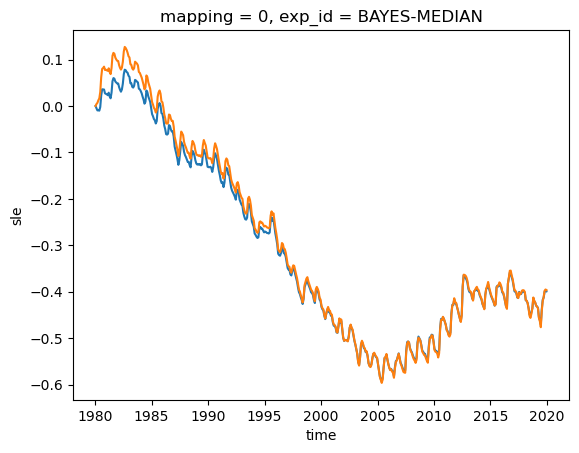

In [82]:
fig = plt.figure()
ax = fig.add_subplot(111)
basin_sle.sel(exp_id="BAYES-MEDIAN").plot.line(x="time", ax=ax)
domain_sle.sel(exp_id="BAYES-MEDIAN").plot.line(x="time", ax=ax)
#scalar_mass.plot.line(x="time", hue="exp_id", ax=ax)

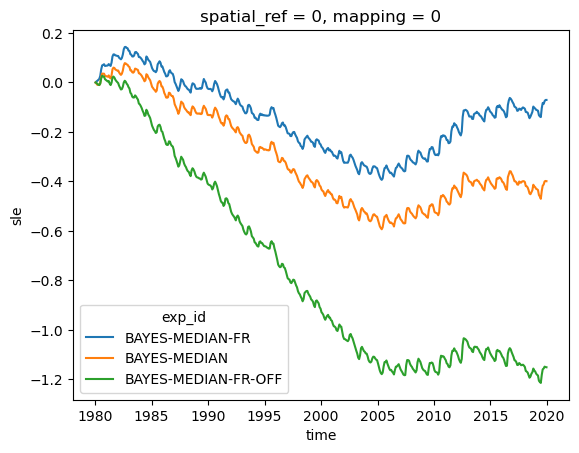

In [22]:
basin_sle.plot.line(x="time", hue="exp_id")

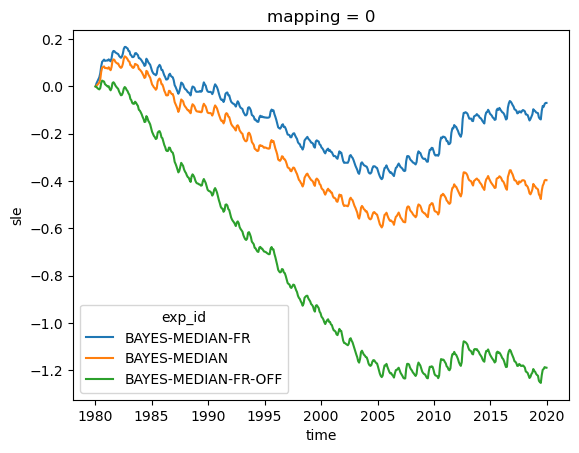

In [28]:
domain_sle.plot.line(x="time", hue="exp_id")

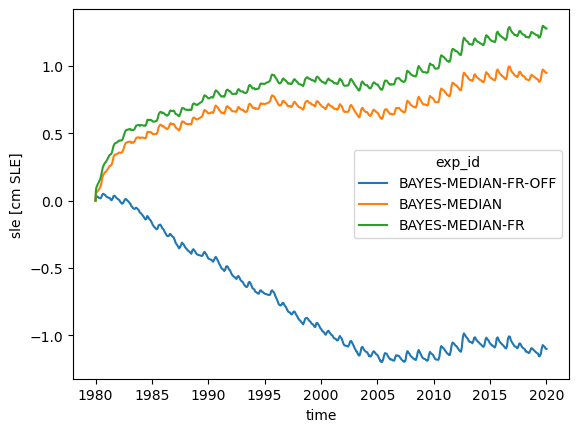

In [30]:
scalar_sle.plot.line(x="time", hue="exp_id")

In [86]:
mou_gis[mou_gis["Year"] == 1985]

,Year,Cumulative ice sheet mass change (Gt),Cumulative surface mass balance anomaly (Gt),Cumulative ice discharge anomaly (Gt),Cumulative ice sheet mass change uncertainty (Gt),Cumulative surface mass balance anomaly uncertainty (Gt),Cumulative ice discharge anomaly uncertainty (Gt),Rate of ice sheet mass change (Gt/yr),Rate of surface mass balance (Gt/yr),Rate of ice discharge (Gt/yr),Rate of ice sheet mass change uncertainty (Gt/yr),Rate of surface mass balance uncertainty (Gt/yr),Rate of ice discharge uncertainty (Gt/yr),Date,SLE (cm),SLE uncertainty (cm),Basin
13,1985.0,0.0,0.0,0.0,232.075012,207.29011,104.353349,4.4268,462.15,-457.7232,57.282317,55.400612,14.561455,1985-01-01,0.0,-0.064021,GIS


In [91]:
import pandas as pd